# CIFAR10 CNN
This is a practice/notes of CIFAR-10 with CNN. Following example from: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
## Imports

In [4]:
from IPython.display import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import time
import math
from sklearn.metrics import confusion_matrix
from datetime import timedelta

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

## Load Data
Try to load data from the CIFAR-10 dataset. Following the suggestion of Pedersen, I try not to use the CIFAR-10.py from TensorFlow and re-write a much simpler version of it. <br><b>Notes:</b> Different from Pedersen's implementation, this whole implementation was build on <font color="red">Python 2.7</font>. Therefore, some function such as the method used to download the CIFAR-10 dataset was totally different from what should be implement via Python 3.

In [5]:
import CIFAR10 as cf10
from CIFAR10 import IMAGE_SIZE, NUM_CHANNELS, NUM_CLASSES
cf10.maybe_download_and_extract()
# Get Training data
train_image, train_cls, train_cls_one_hot = cf10.get_training_data()
# Get Test data
test_image, test_cls, test_cls_one_hot = cf10.get_test_data()

Fetching data from: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Extracting data from: cifar-10-python.tar.gz
Training data acquire successfully!
The Training-set contain [50000] images
Test data acquire successfully!
The Test-set contain [10000] images


### Plot images
Some helper functions from the example to view part of the dataset

In [6]:
class_names = cf10.get_class_names()

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

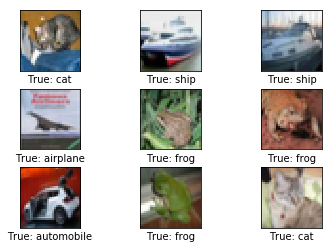

In [7]:
# Get the first images from the test-set.
images = test_image[0:9]

# Get the true classes for those images.
cls_true = test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

## Setting Variables
### Placeholder variables

Everytime we execute the TensorFlow computational graph, we can feed different values to the Placeholder variables. These Placeholder variable are multi-dimensional array called <b>tensor</b> and the data-type is set to <b>float32</b>. 

<font color="red">**None means it can hold an arbitrary number of images.</font>
<br>The images input shape: [None, img_size, img_size, num_channels]
<br>- Each image being <b>img_size</b> pixels high and <b>img_size</b> pixels wide and with <b>num_channels</b> colour channels.
<br>The labels shape: [None, num_classes]
<br>The class shape: [None]

In [8]:
# TensorFlow expect 4-dim input X, so we have to reshape x
# Output: [num_images, img_height, img_width, num_channels]
# Note that all input is square, thus, img_height == img_width == img_size
# num_images can be inferred automatically by using -1 
x = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS], name='x')

# Label y associated with X 
# Output: [arbitrary, num_classes]
# 10 classes for eachd digit in this case
# Each example's class is represent in vector e.g. For class 5 = [0,0,0,0,0,1,0,0,0,0]
y_true = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name='y_true')

# Class-number y associated with X 
# Output: [arbitrary]
# Each example's class is represent in number e.g. [5]
y_true_cls = tf.argmax(y_true, dimension=1)

## Helper Function
In ipython there is execution sequence, so all helper function should be execute before proceed.
<br>
**Note that the initialization is not actually done at this point, it defines the TensorFlow graph.

### Helper-function - Creating Pre-Processing
Helper-functions create the part of the TensorFlow computational graph that pre-processes the input images. Nothing is actually calculated at this point, the function merely adds nodes to the computational graph for TensorFlow.

The pre-processing is different for training and testing of the neural network:

<ul>
<li>For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.</li>
<li>For testing, the input images are cropped around the centre and nothing else is adjusted.</li>
</ul>

In [9]:
img_size_cropped = 24

def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, NUM_CHANNELS])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For test, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [10]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [11]:
distorted_images = pre_process(images=x, training=True)

### Helper-function - Creating Main Processing (PrettyTensor)
Helper-function creates the main part of the convolutional neural network. By using <b>PrettyTensor</b> with <b>Normal Mode</b>, TensorFlow graph build can be simplified. 
<br>Doc: https://github.com/google/prettytensor/blob/master/docs/PrettyTensor.md
<br>PrettyTensor has 3 modes of operation that share the ability to chain methods.
<ol>
<li><b>Normal mode</b>
<br>- Create a new PrettyTensor, everytime method is called
<br>- Easy to branch<br>i) result = pretty_tensor.wrap(input_data).flatten...</li>
<li><b>Sequential mode</b>
<br>- Keeps track of the most recent output tensor
<br>- Breaking call chains into multiple statements
<br>i) seq = pretty_tensor.wrap(input_data).sequential()
<br>ii) seq.flatten()...
<br>iii) result = seq.softmax(labels, name=softmax_name))</li>
<li><b>Branch and Join</b>
<br>- Building more complex network
<br>- Operations: branch,join,subdivide
</li>
</ol>

In [12]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=NUM_CLASSES, labels=y_true)

    return y_pred, loss

### Helper-function - Creating Neural Network
Helper-function creates the full neural network, which consists of the pre-processing and main-processing defined above.

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [13]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=x, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Helper-function - Get a random training-batch
Batch gradient descent is used here to avoid the model using all image at once. Small batch of images is used in each iteration by the optimizer.

In [14]:
train_batch_size = 64

def random_batch():
    # Number of images in the training-set.
    num_images = len(train_image)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = train_image[idx, :, :, :]
    y_batch = train_cls_one_hot[idx, :]

    return x_batch, y_batch

### Helper-function - Plot example errors
Function for plotting examples of images from the test-set that have been mis-classified.

In [15]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_image[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function - Plot confusion matrix

In [16]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=test_cls,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(NUM_CLASSES):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(NUM_CLASSES)]
    print("".join(class_numbers))

### Helper-functions - Calculating classifications
This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. If your computer crashes then you can try and lower the batch-size.

In [17]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_one_hot, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

### Helper-functions for the classification accuracy
This function calculates the classification accuracy given a boolean array whether each image was correctly classified. E.g. classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4. The function also returns the number of correct classifications.

In [18]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

### Helper-function for showing the performance
Function for printing the classification accuracy on the test-set.
It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [19]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

# Architecture

### Create Neural Network for Training Phase
First create a TensorFlow variable that keeps track of the number of optimization iterations performed so far, save this variable with all the other TensorFlow variables in the checkpoints.

Note that trainable=False which means that TensorFlow will not try to optimize this variable.

In [20]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
# Create the neural network to be used for training. 
# y_pred and loss was returned, but we only need the loss-function during training.
_, loss = create_network(training=True)
# Collecting loss for TensorBoard
tf.summary.scalar("loss", loss)
# As usual AdamOptimizer will be used to minimize the loss-function
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Create Neural Network for Test Phase / Inference
Now create the neural network for the test-phase. 
Differen from training, we only need y_pred.

In [21]:
# Output: [num of image, num of claases]
y_pred, _ = create_network(training=False)

# Convert to one-hot 
# Output: [num of image,]
y_pred_one_hot = tf.argmax(y_pred, dimension=1)

# Boolean vector comparing pred and actual class of each image.
# Output: [num of image,]
correct_prediction = tf.equal(y_pred_one_hot, y_true_cls)

# Cast booleans to floats, False = 0, True = 1
# Calculate the average of these number
# Output: float32
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Collecting accuracy for TensorBoard
tf.summary.scalar("accuracy", accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

### Saver
Save variables of the neural network to reloaded quickly without having to train the network again.
<br>Doc: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/04_Save_Restore.ipynb

**Note that nothing is actually saved at this point, which will be done further below.

In [22]:
saver = tf.train.Saver()

### Getting the Weights
Since the network is constructed using Pretty Tensor, all the variables of the layers are created indirectly by Pretty Tensor. We therefore have to retrieve the variables from TensorFlow.

By using the name we set in main_network() and create_network(). These are also called variable scopes. Pretty Tensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

In [23]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' given by PrettyTensor
    # in the scope of the target layer_name.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

weights_conv1 = get_weights_variable(layer_name='layer_conv1')
#tf.summary.scalar("conv1_weight", weights_conv1)
weights_conv2 = get_weights_variable(layer_name='layer_conv2')
#tf.summary.scalar("conv2_weight", weights_conv2)

### Getting the Layer Outputs
Similarly we also need to retrieve the outputs of the convolutional layers. The function for doing this is slightly different than the function above for getting the weights. Here we instead retrieve the last tensor that is output by the convolutional layer.

In [24]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # !!! This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

output_conv1 = get_layer_output(layer_name='layer_conv1')
#tf.summary.scalar("conv1_output", output_conv1)
output_conv2 = get_layer_output(layer_name='layer_conv2')
#tf.summary.scalar("conv2_output", output_conv2)

## Main (Execute)

In [25]:
# Create TensorFlow Session to execute the TensorFlow graph
session = tf.Session()
# Collecting accuracy for TensorBoard
# Summaries such as scalars can be seen by running the command below
# tensorboard --logdir="./log"
# http://192.168.0.150:6006
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter('./log', session.graph)

### Executing-function - Perform optimization
This function performs a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations. A checkpoint is saved every 1000 iterations and also after the last iteration.

In [26]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        # !!! Add [global_step, merged, opt] for TensorBoard !!! Very Important, Order has no effect
        i_global, summary, _ = session.run([global_step, merged, optimizer], feed_dict=feed_dict_train)
        writer.add_summary(summary, i)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Restore or initialize variables
Training this neural network may take a long time, especially if you do not have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

If you want to restart the training of the neural network, you have to delete the checkpoints first.

This is the directory used for the checkpoints.

In [24]:
save_dir = 'checkpoints/'
# Create directory if not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'cifar10_cnn')

# Try to restore the latest checkpoint. 
# If checkpoint doesn't exist or TensorFlow graph has been modified, exception will raise.
# When exception appears, initialise will be made
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialise all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
('Restored checkpoint from:', u'checkpoints/cifar10_cnn-200')


In [25]:
def predict_cls_test():
    return predict_cls(images = test_image,
                       labels = test_cls_one_hot,
                       cls_true = test_cls)

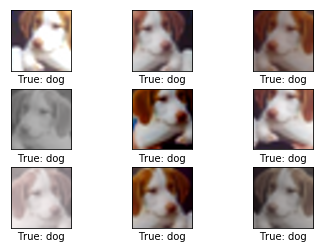

In [26]:
# Try to print some distorted image created with Helper-function pre_process() above
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

def get_test_image(i):
    return test_image[i, :, :, :], test_cls[i]

img, cls = get_test_image(16)
plot_distorted_image(img, cls)

In [27]:
if True:
    optimize(num_iterations=18000)

Global Step:    300, Training Batch Accuracy:  34.4%
Global Step:    400, Training Batch Accuracy:  26.6%
Global Step:    500, Training Batch Accuracy:  37.5%
Global Step:    600, Training Batch Accuracy:  43.8%
Global Step:    700, Training Batch Accuracy:  37.5%
Global Step:    800, Training Batch Accuracy:  42.2%
Global Step:    900, Training Batch Accuracy:  50.0%
Global Step:   1000, Training Batch Accuracy:  51.6%
Saved checkpoint.
Global Step:   1100, Training Batch Accuracy:  42.2%
Global Step:   1200, Training Batch Accuracy:  43.8%
Global Step:   1300, Training Batch Accuracy:  42.2%
Global Step:   1400, Training Batch Accuracy:  54.7%
Global Step:   1500, Training Batch Accuracy:  46.9%
Global Step:   1600, Training Batch Accuracy:  34.4%
Global Step:   1700, Training Batch Accuracy:  56.2%
Global Step:   1800, Training Batch Accuracy:  60.9%
Global Step:   1900, Training Batch Accuracy:  56.2%
Global Step:   2000, Training Batch Accuracy:  48.4%
Saved checkpoint.
Global Ste

Accuracy on Test-Set: 68.4% (6841 / 10000)
Example errors:


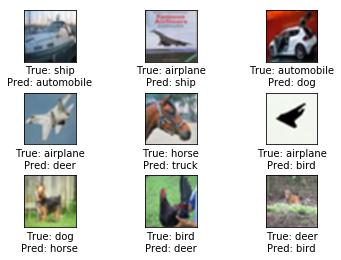

Confusion Matrix:
(array([781,  30,  14,   6,   5,  10,   7,  17,  65,  65]), '(0) airplane')
(array([ 29, 814,   7,   5,   1,   5,   5,   2,  21, 111]), '(1) automobile')
(array([106,  17, 484,  37,  56,  84,  72,  79,  15,  50]), '(2) bird')
(array([ 46,  24,  37, 357,  38, 231, 102,  70,  14,  81]), '(3) cat')
(array([ 34,  16,  41,  25, 515,  51,  65, 193,  13,  47]), '(4) deer')
(array([ 22,  11,  38,  83,  27, 656,  26,  74,  10,  53]), '(5) dog')
(array([ 15,  15,  32,  34,  19,  28, 788,  18,  14,  37]), '(6) frog')
(array([ 20,   7,  11,  17,  22,  75,   9, 785,   2,  52]), '(7) horse')
(array([ 57,  50,   4,   5,   2,   4,   4,   7, 797,  70]), '(8) ship')
(array([ 20,  71,   5,   3,   1,   4,   3,  13,  16, 864]), '(9) truck')
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [29]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Helper-function - Plotting convolutional weights
<font color="red">Require TensorFlow session</font>

In [32]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    # Cast float to int orelse cannot be use as index
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function - Plotting the output of a convolutional layer
<font color="red">Require TensorFlow session</font>

In [33]:
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    # Cast float to int orelse cannot be use as index
    num_grids = int(math.ceil(math.sqrt(num_images)))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Min:  -0.63174, Max:   0.65670
Mean: -0.00299, Stdev: 0.16240


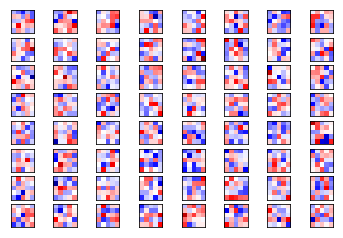

In [34]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -0.19388, Max:   0.17571
Mean: -0.00169, Stdev: 0.03866


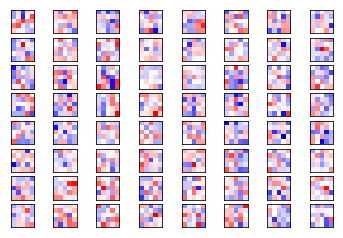

In [35]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

## Output of convolutional layers


In [36]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

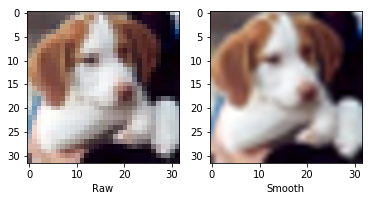

In [37]:
img, cls = get_test_image(16)
plot_image(img)

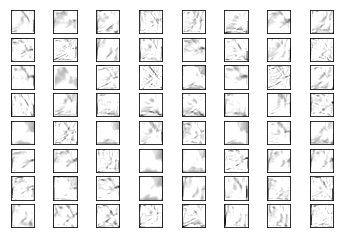

In [38]:
plot_layer_output(output_conv1, image=img)

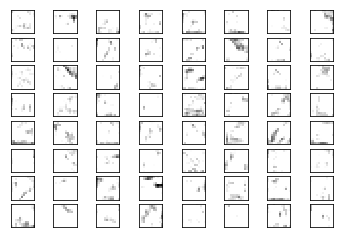

In [39]:
plot_layer_output(output_conv2, image=img)

## Close TensorFlow Session
We are now done using TensorFlow, so we close the session to release its resources.

In [89]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()